In [1]:
%pip install matplotlib
%pip install pandas
%pip install seaborn

import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter

# Suppress the specific DeprecationWarning
warnings.filterwarnings('ignore', category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
input_parquet_file_path = '../data/interm/4.0_commune.parquet'

output_population_tax_revenue_file_path = '../data/interm/5.0_population_tax_revenue.csv'

In [3]:
code_insee_identifier = 'Clean code INSEE'
population_identifier = 'POPULATION TOTALE (MUNICIPALE ET COMPTEE A PART)  - Source saisies application FDL'

data_df = pd.read_parquet(input_parquet_file_path)
data_df[population_identifier] = data_df[population_identifier].fillna(0)

tax_columns = data_df.columns[8:]

In [4]:
# Calculate total tax revenue
data_df['Total Tax Revenue'] = data_df[tax_columns].sum(axis=1)

# Group by 'Clean code INSEE' and 'ANNEE' and sum the total tax revenue
result = data_df.groupby([code_insee_identifier, 'ANNEE'])['Total Tax Revenue'].sum().reset_index()

# Group by 'Clean code INSEE' and 'ANNEE' and take the first non-null value for the population field
population_data = data_df.groupby([code_insee_identifier, 'ANNEE'])[population_identifier].first()

# Merge the population data with the result
result_df = result.merge(population_data, on=[code_insee_identifier, 'ANNEE'], how='left')

# Eliminate rows where the population is NaN or <100(-13234)
result_df_cleaned = result_df.dropna(subset=[population_identifier])
result_df_cleaned = result_df_cleaned[(result_df_cleaned[population_identifier] != 0) & (result_df_cleaned[population_identifier] >= 100)]
result_df_cleaned = result_df_cleaned[(result_df_cleaned['Total Tax Revenue'] != 0) & (result_df_cleaned['Total Tax Revenue'] >= 100)]

result_df_cleaned.rename(columns={population_identifier: 'Population'}, inplace=True)
result_df_cleaned.to_csv(output_population_tax_revenue_file_path, index=False)


In [5]:
# Define a function to format the y-axis labels to display in millions
def human_readable_format(x, pos=None):
    """
    Converts a number into a human-readable format (K, M, B, T).
    
    Parameters:
    x (float): The number to be converted.
    pos (optional): The position (not used, but required for compatibility with matplotlib).

    Returns:
    str: The human-readable format of the number.
    """
    if x >= 1e12:
        return f'{x / 1e12:.1f}T'
    elif x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    elif x >= 1e3:
        return f'{x / 1e3:.1f}K'
    else:
        return str(x)

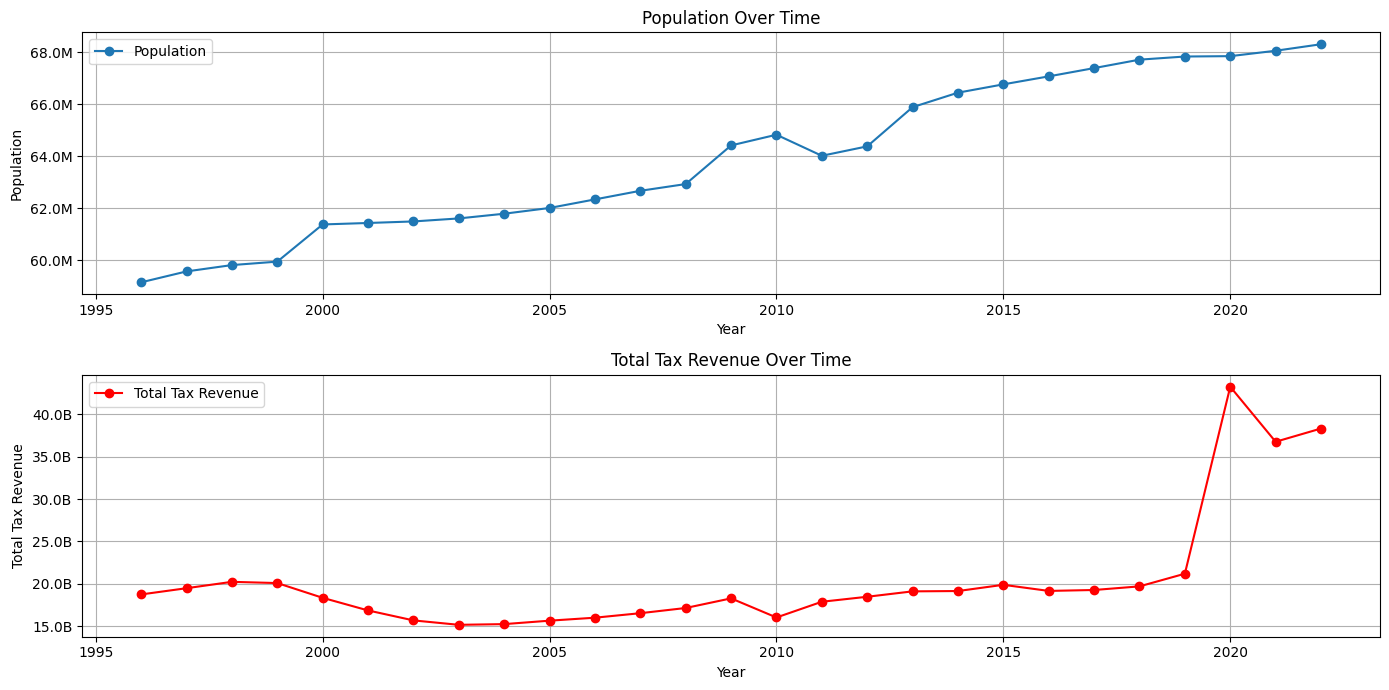

In [6]:
# Aggregate the data by year, summing the values for duplicates
data_agg = result_df_cleaned.groupby('ANNEE').agg({'Total Tax Revenue': 'sum', 'Population': 'sum'}).reset_index()

# Plot population and tax revenue over time
plt.figure(figsize=(14, 7))

# Plot population
plt.subplot(2, 1, 1)
plt.plot(data_agg['ANNEE'], data_agg['Population'], marker='o', linestyle='-', label='Population')
plt.title('Population Over Time')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.legend()

# Plot tax revenue
plt.subplot(2, 1, 2)
plt.plot(data_agg['ANNEE'], data_agg['Total Tax Revenue'], marker='o', linestyle='-', color='r', label='Total Tax Revenue')
plt.title('Total Tax Revenue Over Time')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
plt.xlabel('Year')
plt.ylabel('Total Tax Revenue')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

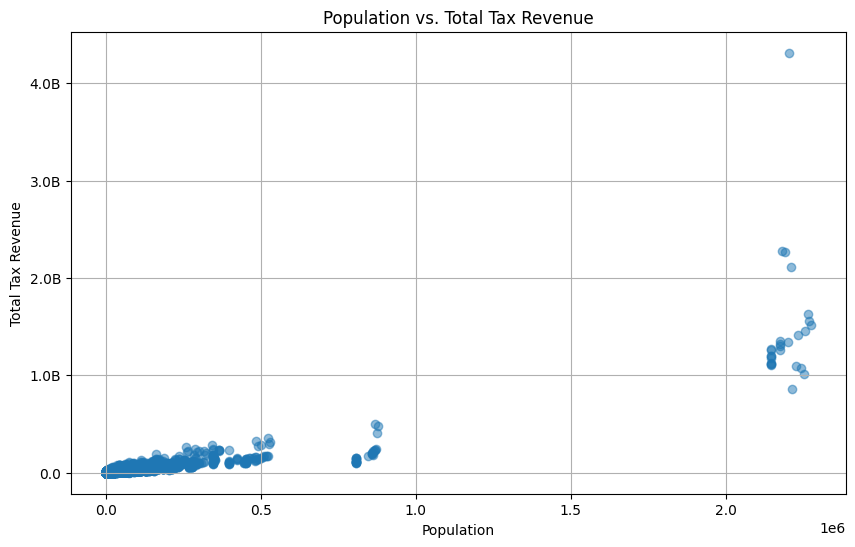

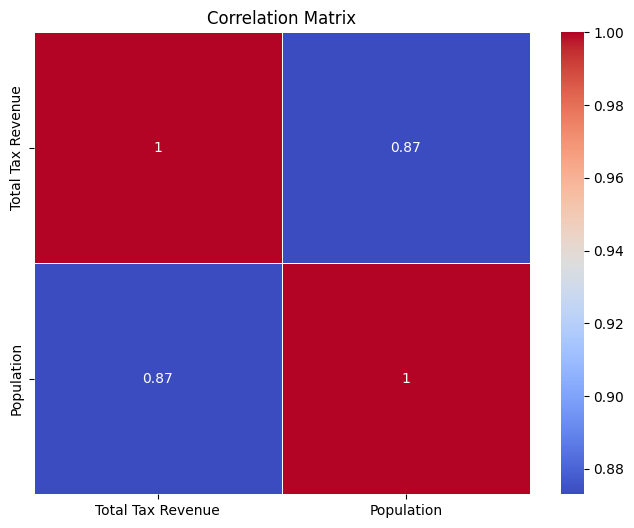

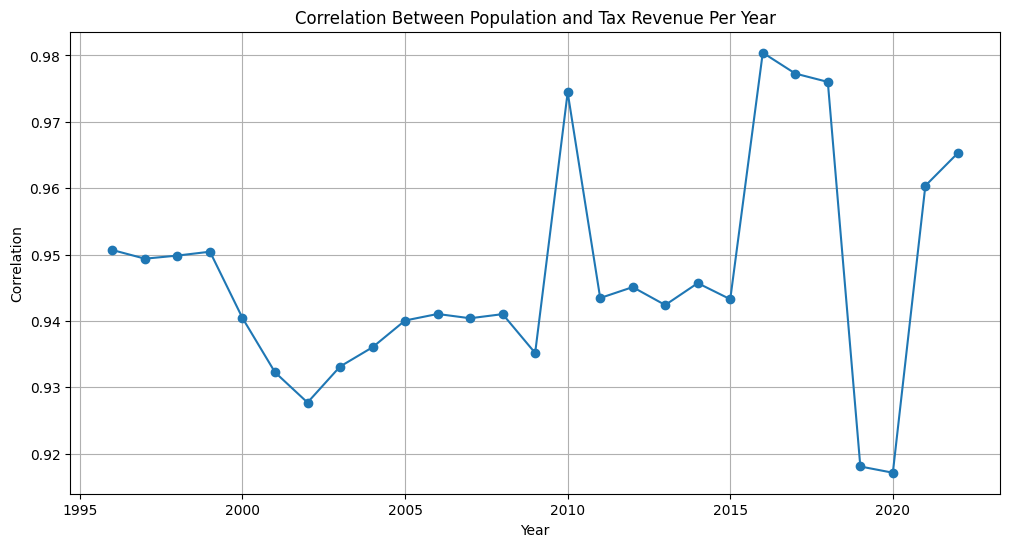

                   Total Tax Revenue  Population
Total Tax Revenue           1.000000    0.872995
Population                  0.872995    1.000000
ANNEE
1996    0.950680
1997    0.949375
1998    0.949845
1999    0.950427
2000    0.940431
2001    0.932256
2002    0.927702
2003    0.933124
2004    0.936034
2005    0.940061
2006    0.941045
2007    0.940401
2008    0.941022
2009    0.935169
2010    0.974431
2011    0.943450
2012    0.945094
2013    0.942395
2014    0.945696
2015    0.943266
2016    0.980406
2017    0.977266
2018    0.976009
2019    0.918068
2020    0.917129
2021    0.960364
2022    0.965296
Name: (Total Tax Revenue, Population), dtype: float64


In [7]:

# Calculate the correlation between population and tax revenue
correlation = result_df_cleaned[['Total Tax Revenue', 'Population']].corr()

# Scatter plot to show the relationship between population and tax revenue
plt.figure(figsize=(10, 6))
plt.scatter(result_df_cleaned['Population'], result_df_cleaned['Total Tax Revenue'], alpha=0.5)
plt.title('Population vs. Total Tax Revenue')
plt.xlabel('Population')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
plt.ylabel('Total Tax Revenue')
plt.grid(True)
plt.show()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Calculate the correlations per year using the 'ANNEE' field
correlations_per_year = result_df_cleaned.groupby('ANNEE')[['Total Tax Revenue', 'Population']].corr().unstack().iloc[:,1]

# Plot the correlations per year
plt.figure(figsize=(12, 6))
plt.plot(correlations_per_year.index, correlations_per_year.values, marker='o')
plt.title('Correlation Between Population and Tax Revenue Per Year')
plt.xlabel('Year')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

# Display the correlation matrix
print(correlation)
# Display the correlations per year
print(correlations_per_year)

In [8]:
del data_df

gc.collect()

15616